<a href="https://colab.research.google.com/github/shiyuhu1933/EC-523-final-project/blob/main/Project_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
import torch
import os
import h5py
import numpy as np
from torchvision.transforms import ToPILImage

drive.mount('/content/gdrive')

DATASET_GOOGLE_DRIVE_PATH = '/content/gdrive/MyDrive/Deep Learning /face_model_hdf5'


def get_configuration(batch_size):
    config = {}
    config['batch_size'] = batch_size
    config['num_workers'] = 1
    return config

def get_file_name(files_list):
  with open(files_list) as f:
    return [line.rstrip()[:] for line in f]



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# dataset class 
class FaceMaskData(torch.utils.data.Dataset):

  def __init__(self, mode, config, transform=None):

    self.data_dir = DATASET_GOOGLE_DRIVE_PATH
    self.transform = transform

    if mode == 'train':
      self.files = get_file_name(os.path.join(self.data_dir, 'train_files.txt'))
    else:
      self.files = get_file_name(os.path.join(self.data_dir, 'test_files.txt'))

    image = []
    label = []

    # iterate hdf5 files listed in txt and store data into self.image and self.label
    for dataset in self.files:
      path = os.path.join(self.data_dir, dataset)
      self.file = h5py.File(path, 'r')
      self.total_num_imgs, self.H, self.W, self.C = self.file['image'].shape
      image.append(self.file['image'][:])
      label.append(self.file['labels'][:])

    self.image = np.vstack(image)
    self.label = np.vstack(label)

    self.num_images = len(self.image) 

  def __getitem__(self, index):
    image = self.image[index]
    label = self.label[index]
    if self.transform:
        image = self.transform(image)
    return image, torch.FloatTensor(label)

  def __len__(self):
    return self.num_images

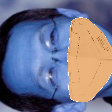

In [8]:
config = get_configuration(16)
dataset = FaceMaskData('train', config)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                              batch_size=config['batch_size'],
                              shuffle=True, 
                              num_workers=config['num_workers'])

for i, data in enumerate(data_loader, 0):
   image, label = data
   image, label = image.cuda(), label.cuda()

# show sample image
to_img = ToPILImage()
image[0].T.size()
to_img(image[0].T)

In [4]:
import os
import random
import math
import datetime
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils import data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.backends import cudnn

import numpy as np 
from PIL import Image
from tqdm import tqdm 
import random 

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch import nn, optim

In [5]:
class IBSA_Block(nn.Module):
  def __init__(self, dim_in, dim_out, stride=1):
    super().__init__()

    self.dim_in, self.dim_out = dim_in, dim_out
    self.bn1 = nn.BatchNorm2d(dim_in, affine=True, track_running_stats=True)
    self.bn2 = nn.BatchNorm2d(dim_out, affine=True, track_running_stats=True)
    self.conv = nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=stride)
    self.mhsa = nn.MultiheadAttention(dim_in)
    self.prelu = nn.PReLU()
  
  def forward(self, input):
    identity = input

    output = self.bn1(input)
    output = self.conv(output)
    output = self.bn2(output)
    output = self.prelu(output)
    output = self.mhsa(output)
    output = self.bn2(output)

    output += identity
    
    return output

In [42]:
import torch
from torch import nn

In [43]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=dilation,
                     groups=groups,
                     bias=False,
                     dilation=dilation)

In [44]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

In [45]:
class IBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1):
        super(IBasicBlock, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.bn1 = nn.BatchNorm2d(inplanes, eps=1e-05, )
        self.conv1 = conv3x3(inplanes, planes)
        self.bn2 = nn.BatchNorm2d(planes, eps=1e-05, )
        self.prelu = nn.PReLU(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn3 = nn.BatchNorm2d(planes, eps=1e-05, )
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.bn1(x)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return out



In [47]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io 
import torch.utils.data
import scipy
from scipy.stats import entropy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [48]:
from torch.nn import Module, Sequential, Conv2d, ReLU,AdaptiveMaxPool2d, AdaptiveAvgPool2d, \
    NLLLoss, BCELoss, CrossEntropyLoss, AvgPool2d, MaxPool2d, Parameter, Linear, Sigmoid, Softmax, Dropout, Embedding
from torch.nn import functional as F


In [55]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=dilation,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class IBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1):
        super(IBasicBlock, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.bn1 = nn.BatchNorm2d(inplanes, eps=1e-05, )
        self.conv1 = conv3x3(inplanes, planes)
        self.bn2 = nn.BatchNorm2d(planes, eps=1e-05, )
        self.prelu = nn.PReLU(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn3 = nn.BatchNorm2d(planes, eps=1e-05, )
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.bn1(x)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return out


class IResNet(nn.Module):
    fc_scale = 7 * 7

    def __init__(self,
                 block, layers, dropout=0, num_features=512, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None, fp16=False):
        super(IResNet, self).__init__()
        self.fp16 = fp16
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes, eps=1e-05)
        self.prelu = nn.PReLU(self.inplanes)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer2 = self._make_layer(block,
                                       128,
                                       layers[1],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block,
                                       256,
                                       layers[2],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block,
                                       512,
                                       layers[3],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.bn2 = nn.BatchNorm2d(512 * block.expansion, eps=1e-05, )
        self.dropout = nn.Dropout(p=dropout, inplace=True)
        self.fc = nn.Linear(512 * block.expansion * self.fc_scale, num_features)
        self.features = nn.BatchNorm1d(num_features, eps=1e-05)
        nn.init.constant_(self.features.weight, 1.0)
        self.features.weight.requires_grad = False

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.1)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, IBasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion, eps=1e-05, ),
            )
        layers = [block(self.inplanes, planes, stride, downsample, self.groups,
                        self.base_width, previous_dilation)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes,
                      planes,
                      groups=self.groups,
                      base_width=self.base_width,
                      dilation=self.dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        with torch.cuda.amp.autocast(self.fp16):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.prelu(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.bn2(x)
            x = torch.flatten(x, 1)
            x = self.dropout(x)
        x = self.fc(x.float() if self.fp16 else x)
        x = self.features(x)
        return x


def _iresnet(arch, block, layers, pretrained, progress, **kwargs):
    model = IResNet(block, layers, **kwargs)
    if pretrained:
        raise ValueError()
    return model


def iresnet18(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet18', IBasicBlock, [2, 2, 2, 2], pretrained,
                    progress, **kwargs)


def iresnet34(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet34', IBasicBlock, [3, 4, 6, 3], pretrained,
                    progress, **kwargs)


def iresnet50(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet50', IBasicBlock, [3, 4, 14, 3], pretrained,
                    progress, **kwargs)


In [59]:
model = iresnet50().cuda()
print (model)

IResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu): PReLU(num_parameters=64)
  (layer1): Sequential(
    (0): IBasicBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): IBas